# Librerias

In [ ]:
!pip install Biopython
!pip install nglview
!pip install freesasa

import freesasa
import numpy as np
from Bio.PDB.PDBParser import PDBParser
import nglview as nv
from Bio.Data.IUPACData import protein_letters_3to1
from Bio.PDB.PDBIO import Select
from Bio.PDB.PDBIO import PDBIO
import math
from Bio.PDB.MMCIFParser import MMCIFParser
from Bio.PDB.MMCIF2Dict import MMCIF2Dict
import Bio.PDB.vectors
from Bio.PDB.vectors import calc_angle
from Bio.PDB.vectors import calc_dihedral
import matplotlib.pyplot as plt
from Bio.PDB.Superimposer import Superimposer
from math import degrees
from pprint import pprint
import pandas as pd
from pandas import Series
import os


     |████████████████████████████████| 2.3MB 2.8MB/s 
     |████████████████████████████████| 5.2MB 2.6MB/s 
  Created wheel for nglview: filename=nglview-2.7.7-cp36-none-any.whl size=6983522 sha256=0c1c06248e2405f0bc17dcc2cad3f6324cbf600f43f6e5131fecd4af18be6693
  Stored in directory: /root/.cache/pip/wheels/24/14/56/fc0406301850d9d017a748b568b2e97566148deda046ac56dc
Successfully built nglview
     |████████████████████████████████| 245kB 2.7MB/s 
  Created wheel for freesasa: filename=freesasa-2.1.0-cp36-cp36m-linux_x86_64.whl size=593114 sha256=63c10ffed7d75e77184dfbef0b1ad14aac856db473eda7b27c15262ed2cbb2fb
  Stored in directory: /root/.cache/pip/wheels/e1/85/81/8ad5e803f82ff5f32d4f43a71be13b29cc916c2c40b9d9d60b
Successfully built freesasa


# Objetivo 1

In [ ]:

parser = PDBParser(PERMISSIVE=1)
structure_id = 'Prot prueba'  
filename = "1mbo.pdb"
structure = parser.get_structure(structure_id, filename)

In [ ]:
  """1. Utilice los comandos anteriores para tratar de identificar el residuo HEMO de la Mb y obtener su id y full_idç
   (hay algún otro residuo que NO es de la proteìna y NO es agua?)"""

for model in structure:
    for chain in model:
        for i, residue in enumerate(chain):
            if residue.id[0] not in [" ", "W"]:
              print(residue.id)

"""Tomo todos los residuos que no son de la proteina (" ") o agua ("W"), el residuo HEMO esta en la posicion 155 y hay otros dos residuos que cumplen esta condicion"""


('H_SO4', 154, ' ')
('H_HEM', 155, ' ')
('H_OXY', 555, ' ')


'Tomo todos los residuos que no son de la proteina (" ") o agua ("W"), el residuo HEMO esta en la posicion 155 y hay otros dos residuos que cumplen esta condicion'

In [ ]:
"""2. Levante un PDB y obtenga: a) el número de cadenas, b) el número de residuos, c) número de átomos totales, d) número de átomos de proteìna, e) número de HETatoms, f) número de átomos de agua."""
cadenas = 0
residuos = 0
atomos = [0]*3
for model in structure:
    for chain in model:
        cadenas += 1
        for residue in chain:
            residuos += 1
            if residue.id[0] == " ":
              pos = 0
            elif residue.id[0] == "W":
              pos = 2
            else:
              pos= 1
            for atom in residue:
              atomos[pos] += 1
atomos_totales = sum(atomos)
print("a) {}  b) {} c) {} d) {}, e) {} f {}".format(cadenas, residuos, atomos_totales, atomos[0], atomos[1], atomos[2]))

a) 1  b) 490 c) 1601 d) 1217, e) 50 f 334


In [ ]:
"""3. Levante un PDB y determine la secuencia de aminoàcidos de cada cadena"""
def seq(filename):
  parser = PDBParser(PERMISSIVE=1)
  structure_id = 'Prot prueba'  
  structure = parser.get_structure(structure_id, filename)
  cadenas = []
  i = 0
  for model in structure:
      for chain in model:
          cadenas.append([])
          for residue in chain:
              if residue.id[0] == " ":
                res = protein_letters_3to1[residue.resname[0]+residue.resname[1:].lower()]
                cadenas[i].append(res)
          i += 1
  #print(cadenas)
  return cadenas
seq("1mbo.pdb")

In [ ]:
"""4. Levante un PDB y obtenga un nuevo PDB que contenga “solo” los CA"""

class CASelect(Select):
     def accept_atom(self, atom):
         if atom.get_id() == "CA":
             return True
         else:
             return False

nueva_estructura = PDBIO()
nueva_estructura.set_structure(structure)
nueva_estructura.save("CA_only.pdb", CASelect())



# Objetivo 2

In [ ]:
parser = PDBParser(PERMISSIVE=1)
structure_id = 'Prot prueba'  
filename = "1mbo.pdb"
structure = parser.get_structure(structure_id, filename)
view = nv.show_biopython(structure)
view

FileNotFoundError: ignored

In [ ]:
pos_hetatoms = []
for residuo in structure.get_residues():
    for atom in residuo.get_atoms():
        if residuo.id[0][0] == "H":
            pos = atom.get_vector()
            pos_hetatoms.append(pos)

cerca = []
n = 1
for residuo in structure.get_residues():
    for atom in residuo.get_atoms():
        if residuo.id[0] == " ":
            pos_atom = atom.get_vector()
            for pos_het in pos_hetatoms:
                if np.linalg.norm(pos_atom -pos_het) < 3:
                    cerca.append(n)
                    break
    n += 1
cerca

[45, 58, 60, 64, 92, 93, 97]

In [ ]:
"""Cree una representación con el nglview, que contenga
La proteína en cartoon
Las aguas en licorice
El cofactor y/o ligando en vwd
Los aminoácidos cercanos al cofactor y/o ligando en licorice"""

view3 = nv.show_biopython(structure)
view3.clear_representations()
view3.add_representation('cartoon', selection='protein', color='blue')
view3.add_representation('licorice', selection='water', color='green')
for j in ["HEM", "SO4", "OXY"]:
    view3.add_representation('licorice', selection=j, color = "yellow")
view3.add_representation('licorice', selection=[cerca], color='red')
view3

NGLWidget()

# Objetivo 3

In [ ]:
parser = PDBParser(PERMISSIVE=1)
structure_id = 'mioglobina'  
filename = '1mbo.pdb'
structure = parser.get_structure(structure_id, filename)

# Actividad 3-1)
a_fe = structure[0]["A"][('H_HEM', 155, ' ')]["FE"]
a_o1 = structure[0]["A"][('H_OXY', 555, ' ')]["O1"]
a_o2 = structure[0]["A"][('H_OXY', 555, ' ')]["O2"]
a_n1 = structure[0]["A"][('H_HEM', 155, ' ')]["NA"]



vector_fe = a_fe.get_vector()
vector_o1 = a_o1.get_vector()
vector_o2 = a_o2.get_vector()
vector_n1 = a_n1.get_vector()

dist_fe_o = a_fe - a_o1
angle_fe_o1_o2 = calc_angle(vector_fe,vector_o1,vector_o2)
diedro_na_fe_o1_o2 = calc_dihedral(vector_fe,vector_o1,vector_o2,vector_n1)

print(dist_fe_o)
print(degrees(angle_fe_o1_o2))
print(degrees(diedro_na_fe_o1_o2))

1.8267047
115.51498744046587
64.31174805887159


In [ ]:
"""2. Genere una función que le permita obtener los ángulos diedros del enlace peptídico (Phi/psi) y represéntelos en un gráfico de ramachandran"""

#obtengo los aminoacidos
residuos = []
for modelo in structure:
  for cadena in modelo:
    for elemento in cadena:
      if elemento.id[0] == " ":

          residuos.append(elemento)
angulos = {"psi": [], "phi": []}
for n in range(len(residuos[:-1])):
  vectores = []
  for j in [n, n+1]:
    for i in ["N", "CA", "C"]:
      vectores.append(residuos[j][i].get_vector())
  psi = math.degrees(Bio.PDB.vectors.calc_dihedral(vectores[0], vectores[1], vectores[2], vectores[3]))
  phi = math.degrees(Bio.PDB.vectors.calc_dihedral(vectores[2], vectores[3],vectores[4], vectores[5]))
  if residuos[n].get_resname() != "GLY":
    angulos["psi"].append(psi)
    angulos["phi"].append(phi)

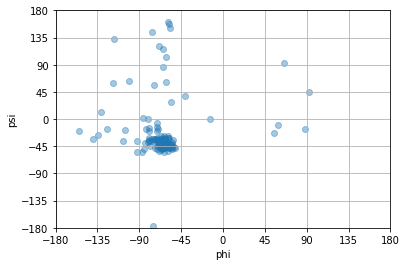

In [ ]:
plt.scatter(angulos["phi"], angulos["psi"], alpha = 0.4)
plt.xlabel("phi")
plt.ylabel("psi")
plt.xlim(-180,180)
plt.ylim(-180,180)
L = [-180,-135,-90,-45,0,45,90,135,180]
plt.xticks(L)
plt.yticks(L)
plt.grid()
#rama = Image.open("ramachandran-plot-standard.jpg")

#plt.show()
#plt.imshow(rama)
#rama.size

(0.0, 140.0)

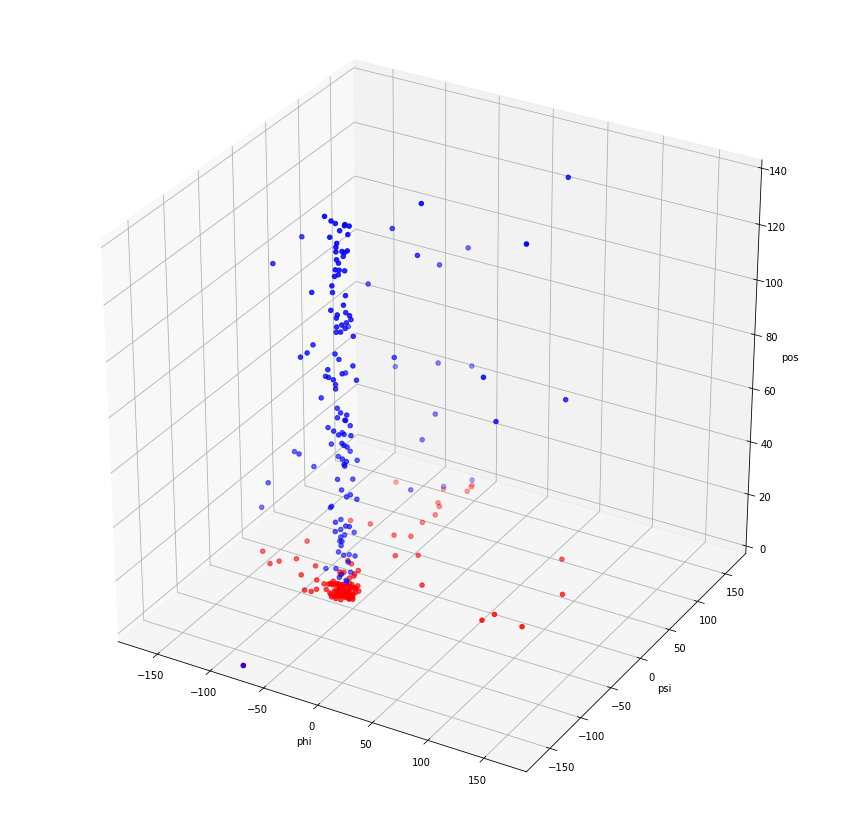

In [ ]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection = "3d")
X, Y, Z = angulos["phi"], angulos["psi"], list(range(len(angulos["phi"])))
ax.scatter(X,Y,Z, color = "blue")
ax.set_xlabel("phi")
ax.set_ylabel("psi")
ax.set_zlabel("pos")
ax.scatter(X,Y,0, color = "red")
ax.axes.set_xlim3d(left=-180, right=180) 
ax.axes.set_ylim3d(bottom=-180, top=180) 
ax.axes.set_zlim3d(bottom=0, top=140) 

In [ ]:
# Ejercicio 3.3
df_angulos = pd.DataFrame(angulos)

posiciones = range(1, len(df_angulos['psi'])+1) 
estructuras_secundarias = []
for posicion in range(len(df_angulos['psi'])):
    if df_angulos['psi'][posicion] > -77 and df_angulos['psi'][posicion]< -15 and df_angulos['phi'][posicion] < -40:
        estructuras_secundarias.append('Alfa Hélice')
    elif df_angulos['psi'][posicion] > 15 and df_angulos['phi'][posicion] < -40:
        estructuras_secundarias.append('Hoja Plegada Beta')
    else:
        estructuras_secundarias.append('Otra Estructura')
df_angulos['Estructura Secundaria'] = estructuras_secundarias
df_angulos.insert(0, 'Posición', posiciones)
df_angulos.head(50)

,Posición,psi,phi,Estructura Secundaria
0,1,-177.032702,-75.231460,Otra Estructura
1,2,143.576736,-76.481137,Hoja Plegada Beta
2,3,161.380631,-58.875769,Hoja Plegada Beta
3,4,-35.500711,-65.104226,Alfa Hélice
4,5,-36.070920,-70.738782,Alfa Hélice
5,6,-40.679196,-61.406988,Alfa Hélice
6,7,-35.790074,-68.965438,Alfa Hélice
7,8,-33.211259,-62.032854,Alfa Hélice
8,9,-48.374408,-63.626515,Alfa Hélice
9,10,-45.269258,-78.196300,Alfa Hélice


# Objetivo 4

In [ ]:
#4-1 Alineamiento múltiple de todas las estructuras y estimación de una matriz de distancia (RMSD de CA).

#primero hago una funcion para ir mirando las estructuras

def mirar_de_a_una(directorio):
    for file in os.listdir(directorio):
        if file.endswith(".ent"): #o .pdb o lo que se necesite
             print(os.path.join(directorio, file))
             parser = PDBParser(PERMISSIVE=1)
             structure_id = os.path.join(directorio, file)
             structure = parser.get_structure(structure_id, file)
             view = nv.show_biopython(structure)
             yield

mirar_struc = mirar_de_a_una("H:\descargas\hemos")


In [ ]:
next(mirar_struc)
view

In [ ]:
#reciclo la funcion seq() del 2-3 para obtener las secuencias de todas las proteinas 
seqs_hemos = []
for file in os.listdir("H:\descargas\hemos\ents"):
  if file.endswith(".ent"): #o .pdb o lo que se necesite
    #print(seq(file))
    seqs_hemos.append("".join(seq(file)[0]))


FileNotFoundError: ignored

In [ ]:
#defino la proteina referencia y la movil

referencia = parser.get_structure("pdb6kao.ent", "pdb6kao.ent")
movil =  parser.get_structure("pdb6kap.ent", "pdb6kap.ent")
prots = [referencia, movil]
sup_ref = []
sup_movil = []
sups = [sup_ref, sup_movil]
for i, prot in enumerate(prots):
    for modelo in prot:
        for cadena in modelo:
            for residuo in cadena:
                if residuo.get_id()[0] == " ":
                    for atomo in residuo:
                        if atomo.get_id() == "CA":
                            sups[i].append(atomo)



Imposer = Superimposer()
Imposer.set_atoms(sups[0], sups[1])
print(Imposer.rms)

In [ ]:
#creo funcion para luego expandir, para empezar solo tomo la primer cadena del primer modelo
def calcular_rmsd(ref, mov):
    referencia = parser.get_structure(ref, ref)
    movil =  parser.get_structure(mov, mov)
    prots = [referencia, movil]
    sup_ref = []
    sup_movil = []
    sups = [sup_ref, sup_movil]
    for i, prot in enumerate(prots):
        cadena = prot[0]["A"]
        for residuo in cadena:
            if residuo.get_id()[0] == " ":
                for atomo in residuo:
                    if atomo.get_id() == "CA":
                        sups[i].append(atomo)
    Imposer = Superimposer()
    Imposer.set_atoms(sups[0], sups[1])
    return Imposer.rms
%cd H:\descargas\hemos\ents

In [ ]:
directorio = "H:\descargas\hemos\ents"
nombres = []
for file1 in os.listdir(directorio):
    if file1.endswith(".ent"):
        nombres.append(file1.rstrip(".ent"))
array = np.zeros((10,10))
i = 0
for file1 in os.listdir(directorio):
    if file1.endswith(".ent"):
        j = 0
        for file2 in os.listdir(directorio):
            if file2.endswith(".ent"): 
                array[i][j] = calcular_rmsd(file1, file2)
                j += 1
        i += 1
df = pd.DataFrame(array, index=nombres, columns=nombres)  

In [ ]:
print(df.round(2))
plt.imshow(df, cmap = "magma")
plt.colorbar()

In [ ]:
# 4-3
#Aca quiza deberia descartar los atomos del esqueleto.. pero queda para otro momento
for file in os.listdir(directorio):
    if file.endswith(".ent"):
        prot = freesasa.Structure(file)
        sasa = freesasa.calc(prot)
        areas = sasa.residueAreas()
        superficie = []
        core = []
        areas_exp_total = 0
        for aa in areas["A"]:
            if areas["A"][aa].relativeTotal > 0.5:
                superficie.append(areas["A"][aa].residueType)
            else:
                core.append(areas["A"][aa].residueType)
            areas_exp_total += areas["A"][aa].relativeTotal
        serie_S = Series(superficie)
        res = serie_S.value_counts(normalize=True)
        res.plot.bar()
        print(file, "Superficie")
        plt.show()
        serie_C = Series(core)
        res = serie_C.value_counts(normalize=True)
        res.plot.bar()
        print(file, "Core")
        plt.show()
        

     |████████████████████████████████| 245kB 4.2MB/s 
  Created wheel for freesasa: filename=freesasa-2.1.0-cp36-cp36m-linux_x86_64.whl size=593121 sha256=757817d84cbbaf3df82a933cee29732135cf19a1e978b6fa852740586b0ca891
  Stored in directory: /root/.cache/pip/wheels/e1/85/81/8ad5e803f82ff5f32d4f43a71be13b29cc916c2c40b9d9d60b
Successfully built freesasa
